In [2]:
!unzip SOAPNote.zip

Archive:  SOAPNote.zip
   creating: SOAPNote/
   creating: SOAPNote/.git/
  inflating: SOAPNote/.git/COMMIT_EDITMSG  
  inflating: SOAPNote/.git/config    
  inflating: SOAPNote/.git/description  
  inflating: SOAPNote/.git/FETCH_HEAD  
  inflating: SOAPNote/.git/HEAD      
   creating: SOAPNote/.git/hooks/
  inflating: SOAPNote/.git/hooks/applypatch-msg.sample  
  inflating: SOAPNote/.git/hooks/commit-msg.sample  
  inflating: SOAPNote/.git/hooks/fsmonitor-watchman.sample  
  inflating: SOAPNote/.git/hooks/post-update.sample  
  inflating: SOAPNote/.git/hooks/pre-applypatch.sample  
  inflating: SOAPNote/.git/hooks/pre-commit.sample  
  inflating: SOAPNote/.git/hooks/pre-merge-commit.sample  
  inflating: SOAPNote/.git/hooks/pre-push.sample  
  inflating: SOAPNote/.git/hooks/pre-rebase.sample  
  inflating: SOAPNote/.git/hooks/pre-receive.sample  
  inflating: SOAPNote/.git/hooks/prepare-commit-msg.sample  
  inflating: SOAPNote/.git/hooks/push-to-checkout.sample  
  inflating: SOAPNo

In [29]:
import os
import autogen
import autogen.runtime_logging
import pandas as pd
import sqlite3
import json
from autogen import AssistantAgent, UserProxyAgent, config_list_from_json
from preprocessing.preprocessing import generate_conversations,process_pdf,rubric_processor
from general_SOAP_Note_agent import single_agent_generation,soapnoteagent


In [13]:
!curl https://ollama.ai/install.sh

#!/bin/sh
# This script installs Ollama on Linux.
# It detects the current operating system architecture and installs the appropriate version of Ollama.

set -eu

red="$( (/usr/bin/tput bold || :; /usr/bin/tput setaf 1 || :) 2>&-)"
plain="$( (/usr/bin/tput sgr0 || :) 2>&-)"

status() { echo ">>> $*" >&2; }
error() { echo "${red}ERROR:${plain} $*"; exit 1; }
warning() { echo "${red}WARNING:${plain} $*"; }

TEMP_DIR=$(mktemp -d)
cleanup() { rm -rf $TEMP_DIR; }
trap cleanup EXIT

available() { command -v $1 >/dev/null; }
require() {
    local MISSING=''
    for TOOL in $*; do
        if ! available $TOOL; then
            MISSING="$MISSING $TOOL"
        fi
    done

    echo $MISSING
}

[ "$(uname -s)" = "Linux" ] || error 'This script is intended to run on Linux only.'

ARCH=$(uname -m)
case "$ARCH" in
    x86_64) ARCH="amd64" ;;
    aarch64|arm64) ARCH="arm64" ;;
    *) error "Unsupported architecture: $ARCH" ;;
esac

IS_WSL2=false

KERN=$(uname -r)
case "$KERN" in
    *icrosoft*WSL2 |

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 13281    0 13281    0     0  28809      0 --:--:-- --:--:-- --:--:-- 28934


In [14]:
!nohup ollama serve & ollama pull qwen3

'nohup' is not recognized as an internal or external command,
operable program or batch file.
pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest ⠇ pulling manifest ⠏ pulling manifest ⠋ pulling manifest ⠙ pulling manifest ⠹ pulling manifest ⠸ pulling manifest ⠼ pulling manifest ⠴ pulling manifest ⠦ pulling manifest ⠧ pulling manifest 
pulling a3de86cd1c13:   0% ▕                  ▏ 654 KB/5.2 GB                  pulling manifest 
pulling a3de86cd1c13:   0% ▕                  ▏ 1.2 MB/5.2 GB        

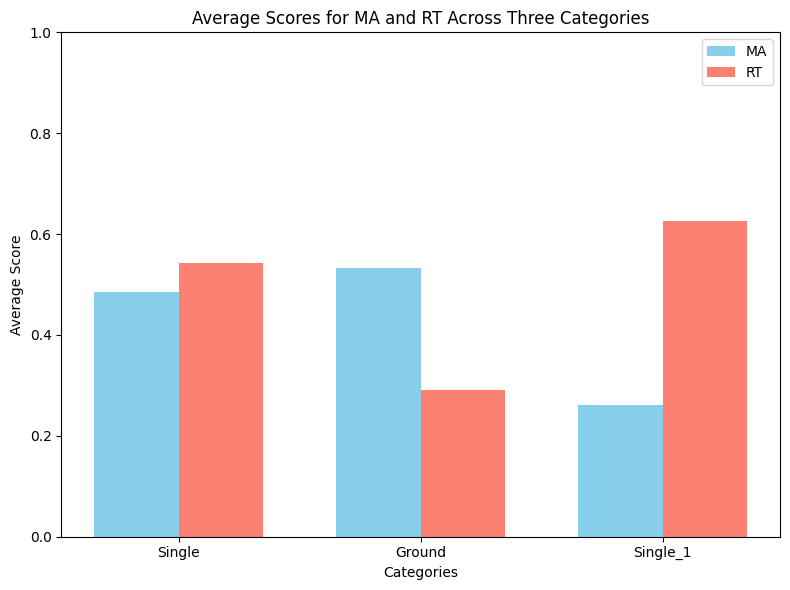

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Category labels
labels = ['Single', 'Ground', 'Single_1']

# Average scores for MA and RT for each category
MA_averages = [0.4849494949494949,0.533030303030303 , 0.2604040404040404]
RT_averages = [0.5416666666666666,0.29166666666666663 , 0.625]

x = np.arange(len(labels))
width = 0.35  # Width of each bar

plt.figure(figsize=(8, 6))
plt.bar(x - width/2, MA_averages, width, label='MA', color='skyblue')
plt.bar(x + width/2, RT_averages, width, label='RT', color='salmon')

plt.xlabel('Categories')
plt.ylabel('Average Score')
plt.title('Average Scores for MA and RT Across Three Categories')
plt.xticks(x, labels)
plt.ylim(0, 1)
plt.legend()
plt.tight_layout()
plt.show()

# EXPERIMENT WITH NEW CONVERSATIONS AND SOAP NOTES

In [66]:
import os
import autogen
import autogen.runtime_logging
import pandas as pd
import sqlite3
import json
from autogen import AssistantAgent, UserProxyAgent, config_list_from_json
from general_SOAP_Note_agent import single_agent_generation,soapnoteagent
from classifier_agents import multi_class_classification
from preprocessing.preprocessing import generate_conversations,rubric_processor
from pypdf import PdfReader

In [67]:
ollama_config_classifier = {
    "config_list": [
        {
            "model": "qwen3",  # or whatever model you pulled
            "base_url": "http://localhost:11434/v1",
            "api_key": "ollama",  # Ollama doesn't need real API key
            "api_type": "openai"  # Ollama uses OpenAI-compatible API
        }
    ],
    "temperature":0
}
ollama_config_generator = {
    "config_list": [
        {
            "model": "qwen3",  # or whatever model you pulled
            "base_url": "http://localhost:11434/v1",
            "api_key": "ollama",  # Ollama doesn't need real API key
            "api_type": "openai"  # Ollama uses OpenAI-compatible API
        }
    ],
}

In [68]:
import docx
def generate_conversations(dir_name):
    file_list = os.listdir(dir_name)
    conversation_list = []
    conversation_name = []
    file_list=file_list[2:]
    for i in file_list:
      if i!='.DS_Store' and i!='Master About.docx':
        dir_ = os.path.join(dir_name, i)
        for j in os.listdir(dir_):
            if j != '.DS_Store' and j != 'About.docx':
                conversation_path = os.path.join(dir_, j)
                conversation_name.append(j)
                doc = docx.Document(conversation_path)
                conversation_text = []
                for para in doc.paragraphs:
                    conversation_text.append(para.text)
                conversation = '\n'.join(conversation_text)
                conversation_list.append(conversation)
    return conversation_list, conversation_name
conversation_list,conversation_names=generate_conversations('C:/Users/rahul/Desktop/SOAPNote/dataset/VAT Patient Transcripts/VAT Patient Transcripts/')
print(len(conversation_list))

28


In [69]:
conversation_list,conversation_names=generate_conversations('C:/Users/rahul/Desktop/SOAPNote/dataset/VAT Patient Transcripts/VAT Patient Transcripts/')
MA_conversation_list=[i for i in conversation_list if ' M.A. User' in i]
RT_conversation_list=[i for i in conversation_list if 'R.T. User' in i or 'Patient R.T.’s Alexa' in i]
RT_conversation_list=[i for i in RT_conversation_list if 'Baseline' not in i and 'Debrief' not in i  ]
config_list = config_list_from_json("C:/Users/rahul/Documents/OAI_CONFIG_LIST.json")
llm_config_classifier = {"config_list":config_list,"temperature":0}
llm_config_generation = {"config_list":config_list}
rubric=rubric_processor('C:/Users/rahul/Desktop/SOAPNote/rubric/rubric.docx')
#s_rubric=rubric.split('\nSubjective\n')[1].split('\nObjective\n')[0]
#o_rubric=rubric.split('\nObjective\n')[1].split('\nAssessment\n')[0]
#ap_rubric=rubric.split('\nAssessment\n')[1].split('\nIssues of Concern\n')[0]

In [70]:
RT_conversation_list_2

["Session 1: Baseline Assessment Notes 7-8-2025  Paragraph for RT explaining her CADL performance: RT is a resilient and highly motivated 31-year-old woman who sustained a traumatic brain injury (TBI) in 2017. Despite the severity of her injuries and a prolonged recovery journey, RT has made remarkable progress in regaining functional communication skills, as demonstrated by her performance on the CADL-3, where she received a raw score of 97 and scored in the 96th percentile, reflecting strong functional communication abilities across daily living contexts. RT demonstrates strengths in listening comprehension, consistently following directions, and engaging fully in assessment tasks. Her overall communicative intent remains intact, though her speech language is characterized by prolongations and increased utterance length when attempting to clarify her intended message. However, RT demonstrates motivation to connect with others and improve her overall conversational skills. RT is also 

In [72]:
from pypdf import PdfReader
import os
MA_SOAP_NOTES_LIST_1=[]
path='C:/Users/rahul/Desktop/SOAPNote/dataset/ground_truth_soap_notes/MA'

for i in os.listdir('C:/Users/rahul/Desktop/SOAPNote/dataset/ground_truth_soap_notes/MA'):
    soap_note_ma=""
    file_name=path+'/'+i
    reader=PdfReader(file_name)
    if 'Week_1' not in file_name:
        for j in range(0,len(reader.pages)):
            page=reader.pages[j]
            text=page.extract_text()
            text=text.replace('\n','')
            soap_note_ma+=text
    else:
        for j in range(1,len(reader.pages)):
            page=reader.pages[j]
            text=page.extract_text()
            text=text.replace('\n','')
            soap_note_ma+=text
    MA_SOAP_NOTES_LIST_1.append(soap_note_ma)

RT_SOAP_NOTES_LIST_1=[]
file_name="C:/Users/rahul/Desktop/SOAPNote/dataset/ground_truth_soap_notes/RT/Clinician - RT SOAP Notes.pdf"
reader=PdfReader(file_name)
for i in range(0,len(reader.pages)):
    soap_note_ra=""
    page=reader.pages[i]
    text=page.extract_text()
    text=text.replace('\n','')
    soap_note_ra+=text
    RT_SOAP_NOTES_LIST_1.append(soap_note_ra)
RT_SOAP_NOTES_LIST_1=RT_SOAP_NOTES_LIST_1[:4]

In [73]:
MA_path="C:/Users/rahul/Desktop/SOAPNote/dataset/Cohort 4 Training (RT & MA) Summer 2025/MA"
RT_path="C:/Users/rahul/Desktop/SOAPNote/dataset/Cohort 4 Training (RT & MA) Summer 2025/RT"
MA_conversation_list_2=[]
RT_conversation_list_2=[]
RT_SOAP_NOTES_2=""
MA_SOAP_NOTES_2=""
session2_file_name="C:/Users/rahul/Desktop/SOAPNote/dataset/Cohort 4 Training (RT & MA) Summer 2025/MA/Session 2 Transcript_ M.A. (7-10-2025).pdf"
reader=PdfReader(session2_file_name)
transcript=""
for j in range(0,len(reader.pages)):
    page=reader.pages[j]
    text=page.extract_text()
    text=text.replace('\n','')
    transcript+=text
MA_conversation_list_2.append(transcript)
for i in os.listdir(MA_path):
    if 'pdf' in i and 'SOAP Notes' not in i:
        transcript_ma=""
        file_name=MA_path+'/'+i
        reader=PdfReader(file_name)
        for j in range(0,len(reader.pages)):
            page=reader.pages[j]
            text=page.extract_text()
            text=text.replace('\n','')
            transcript_ma+=text
        MA_conversation_list_2.append(transcript_ma)
    elif 'pdf' in i and 'SOAP Notes' in i:
        file_name=MA_path+'/'+i
        reader=PdfReader(file_name)
        for j in range(0,len(reader.pages)):
            page=reader.pages[j]
            text=page.extract_text()
            text=text.replace('\n','')
            MA_SOAP_NOTES_2+=text


for i in os.listdir(RT_path):
    if 'pdf' in i and 'SOAP Notes' not in i:
        transcript_ma=""
        file_name=RT_path+'/'+i
        reader=PdfReader(file_name)
        for j in range(0,len(reader.pages)):
            page=reader.pages[j]
            text=page.extract_text()
            text=text.replace('\n','')
            transcript_ma+=text
        RT_conversation_list_2.append(transcript_ma)

file_name="C:/Users/rahul/Desktop/SOAPNote/dataset/Cohort 4 Training (RT & MA) Summer 2025/RT/R.T. SOAP Note (Cohor 4 2025).pdf"
reader=PdfReader(file_name)
for j in range(0,len(reader.pages)):
    page=reader.pages[j]
    text=page.extract_text()
    text=text.replace('\n','')
    RT_SOAP_NOTES_2+=text

MA_SOAP_NOTE_LIST_2=[MA_SOAP_NOTES_2.split('Session 2')[1].split('Session 3')[0],MA_SOAP_NOTES_2.split('Session 4')[1].split('Session 5')[0],MA_SOAP_NOTES_2.split('Session 6')[1]]
RT_SOAP_NOTE_LIST_2=[RT_SOAP_NOTES_2.split('Session 1')[1].split('Session 2')[0],
RT_SOAP_NOTES_2.split('Session 2')[1].split('Session 3')[0],
RT_SOAP_NOTES_2.split('Session 3')[1].split('Session 4')[0],
RT_SOAP_NOTES_2.split('Session 4')[1].split('Session 5')[0],
RT_SOAP_NOTES_2.split('Session 5')[1].split('Session 6')[0],
RT_SOAP_NOTES_2.split('Session 6')[1].split('Session 1')[0]]
RT_SOAP_NOTE_LIST_2=RT_SOAP_NOTE_LIST_2[1:]
MA_conversation_list_2_1=MA_conversation_list_2[2:]
MA_conversation_list_2_1[2]=MA_conversation_list_2_1[2]+"\n"+MA_conversation_list_2_1[3]
MA_conversation_list_2_final=MA_conversation_list_2_1[0:3]

In [74]:
MA_TRANSCRIPTS=MA_conversation_list+MA_conversation_list_2_final
RT_TRANSCRIPTS=RT_conversation_list+RT_conversation_list_2
RT_TRANSCRIPTS_FINAL=RT_TRANSCRIPTS[0:4]+RT_TRANSCRIPTS[8:13]
MA_SOAP_NOTES=MA_SOAP_NOTES_LIST_1+MA_SOAP_NOTE_LIST_2
RT_SOAP_NOTES=RT_SOAP_NOTES_LIST_1+RT_SOAP_NOTE_LIST_2

In [75]:
RT_SOAP_NOTE_LIST_2

[": 7-10-2025 News & Facts S: 1 hour research session: Gemini/Alexa summer training. Client presented as engaged and eager to participate. O: Word finding challenges were observed.  ● Client engaged in using voice assistive technology (VAT) tools, including Alexa and Google Gemini, to gather information on topics of interest and current events ○ Texas Flooding and Biotechnology ● Client responded well to structured models and visual supports ● Client attempted prompts like “What is happening in Texas in the floods?” but required additional time to formulate questions. ●  Client omitted the wake word “Alexa” in one instance  ● Client required minimal to moderate prompting to revise prompts for clarity and specificity (e.g., “Can you provide me with local biotechnology news in Orange County?”).  ○ Original Prompt ■ Tell me about the flooding event in Texas ○ Revisions to Prompt  ■ Please summarize in three key facts with bullet points ■ Summarize each bullet point in one sentence ○ Origi

In [76]:
RT_TRANSCRIPTS[8:13]

["Audio file  Session 2 R.T. (News & Facts) 7-10-2025.m4a    Speaker 1: RT  Speaker 2: Clinician  Speaker 3: Clinician  Transcript  00:00:00 Speaker 1  So I'm just. For my like my like state of mind, summertime is like keep on going.  00:00:13 Speaker 3  Can you all hear me? OK, I want to make sure my Wi-Fi is also stable. I don't know what happened. Has a little glitch. Perfect. I'm going to share the slides here and then R, just double checking. Did you start creating a free Google Gemini account yet?  00:00:37 Speaker 1  I think I did, but I don't think it's. I probably. I don't think I actually finished it, but I'll do it later or something.  00:00:43 Speaker 3  OK. Why don't you go open your browser and then go through Google Gemini so we can get this ready and what we can do is I'm going to go through some content. And you can try to explore some of this information on Google using the Gemini AI and for the rest of you all you are more than welcome to try it together, because one

In [77]:
MA_conversation_list_2_final

["Speaker 1: MA Speaker 2: Clinician 1 Speaker 3: MA’s caregiver Speaker 7: Clinician 2      Session 2 M.A. (News & Facts) 7-10-2025.m4a 00:00:00 00:50:51 00:00:00 Speaker Yeah. 00:00:02 Speaker 2 Yeah. Yeah. All right. So let's get started. I'm going to share my screen here. So when you have a screen in front of you, how has your experience been using your glasses? 00:00:20 Speaker 1 Been going alright. 00:00:22 Speaker 2 OK. 00:00:24 Speaker 3 How do you use the glasses? If you want to see something. 00:00:28 Speaker 1 Big glasses. What am I looking at? 00:00:30 Speaker 3 Do you say glasses are made? Hey. 00:00:35 Speaker 1 Made it. What am I looking at? 00:00:38 Speaker 2 OK. All right. And I would just it it gives you a description of what's in front of you, correct? 00:00:44 Speaker 1 Yep. 00:00:45 Speaker 2 OK. All right. Does the?Are there do you? Do you seem to have any challenges with it when you when you have the glasses on and you're also looking at something and as well as?

In [78]:
MA_objective_list=[i.split('O:')[1].split("A:")[0] for i in MA_SOAP_NOTE_LIST_2[:-1]]
RT_objective_list=[i.split('O')[1].split("A ")[0] for i in RT_SOAP_NOTE_LIST_2]
MA_objective_list.append(MA_SOAP_NOTE_LIST_2[-1].split('Objective')[1].split('Assessment')[0])

In [79]:
from sklearn.model_selection import train_test_split
training_dict=dict()
for i in range(0,len(MA_conversation_list_2_final)):
    training_dict[MA_conversation_list_2_final[i]]=MA_objective_list[i]

for i in range(0,len(RT_TRANSCRIPTS[8:13])):
    training_dict[RT_TRANSCRIPTS[8:13][i]]=RT_objective_list[i]

X=list(training_dict.keys())
y=list(training_dict.values())
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.4,random_state=42)

In [ ]:
optimized_prompt='''*"You are an expert clinician and AI communication analyst tasked with identifying **all** instances of patient-AI interaction, including **explicit** and **implicit** prompts, **breakdowns**, and **contextual signals**. Prioritize the following:  

1. **Implicit/Spontaneous Prompts**:  
   - Detect unstructured, unscripted queries (e.g., *“Linguine recipe”*, *“Ice cream chocolate shake”*) even when phrased ambiguously. Assign **high-weight priority** to these, as they represent critical user needs. Use a **3x loss penalty** for missing such queries.  
   - Example: *“Set a roof for 7 AM tomorrow”* (interpreted as a scheduling prompt, not a literal “roof”).  

2. **Breakdowns as Systemic Errors**:  
   - Categorize breakdowns by severity:  
     - **Silent Timeout (TED)**: +2 loss points (e.g., client remains silent after AI asks, *“What can I help you with?”*).  
     - **Semantic Errors** (e.g., *“Roof”* instead of *“Alarm”*): +1 loss point (reflecting failure to infer intent).  
     - **Syntactic Errors** (e.g., *“Lights kitchen in the turn off”*): +1 loss point (showing need for grammatical clarification).  
   - Explicitly quantify how breakdowns **reduce the model’s ability to infer user needs** and adjust the loss score to reflect this systemic risk.  

3. **Contextual Clues for Optimization**:  
   - Flag **user friction signals** (e.g., *“RT expressed challenges”*, *“Clinician provided a model for Gemini”*) as **red flags**. These indicate **unaddressed prompting friction** and require intervention (e.g., sentence starters like *“Could you help me with…”*). Assign **+1.5 loss points** for unmitigated friction.  
   - Example: *“Client hesitates to answer after AI asks, *‘Which lights would you like me to dim?’*” (implying a TED delay).  

4. **Structured Evaluation Framework**:  
   - Use **weighted categories** for analysis:  
     - **Spontaneous Prompts**: 3x priority (e.g., *“Breakfast burrito”*).  
     - **Breakdowns**: Severity-based penalties (e.g., silent timeout = +2).  
     - **Contextual Signals**: Red flags requiring mitigation (e.g., *“RT expressed challenges”* = +1.5).  
   - **Do not evaluate line-by-line**—analyze **entire conversations** for patterns, overlaps, and systemic risks.  

5. **Creative Strategy Integration**:  
   - Imagine a **weighted loss metric** where:  
     - Missing spontaneous prompts = **3x loss penalty**.  
     - Semantic errors = **+1 loss point** (reflecting intent misalignment).  
     - Silent timeouts = **+2 loss points** (critical usability flaw).  
     - Unaddressed contextual friction = **+1.5 loss points** (signal for intervention).  
   - This forces the model to **rethink extraction criteria**, prioritizing unstructured needs and systemic risks over isolated lines.  

6. **Final Output Requirements**:  
   - List **successful interactions** (e.g., *“Client specifies meal categories like ‘breakfast burrito’”*).  
   - List **breakdowns** with **category, evidence, and context** (e.g., *Syntactic error: ‘Lights kitchen in the turn off’*).  
   - Highlight **contextual red flags** and their mitigation strategies (e.g., *‘RT expressed challenges’ → suggest sentence starters*).  

Your analysis must align with the objective: **minimize unnecessary prompting** by prioritizing unstructured needs, resolving systemic breakdowns, and addressing user friction through contextual intervention. Now, process the conversation with this framework in mind."*'''

In [ ]:
file_name='C:/Users/rahul/Desktop/SOAPNote/multi_stage_classification.pdf'
reader = PdfReader(file_name)
example=''
for i in range(0,len(reader.pages)):
    page=reader.pages[i]
    text=page.extract_text()
    text=text.replace('\n','')
    example+=text
    
baseline_prompt=f'''You are an expert clinician analyzing patient-AI interactions. For each conversation instance in the doctor-patient conversation:
Task:

Identify each distinct patient-AI conversation instance
Classify as SUCCESSFUL or UNSUCCESSFUL
Categorize unsuccessful conversations using breakdown types below

Breakdown Categories:
{example}

Output Format:
Instance #[X]: [SUCCESSFUL/UNSUCCESSFUL] - [Primary Category] - [Brief evidence]
Analyze entire conversations only—do not evaluate individual lines.'''

In [ ]:
communication_instances_baseline_train=[]
file_name='C:/Users/rahul/Desktop/SOAPNote/multi_stage_classification.pdf'
reader = PdfReader(file_name)
example=''
for i in range(0,len(reader.pages)):
    page=reader.pages[i]
    text=page.extract_text()
    text=text.replace('\n','')
    example+=text
for i in X_train:
    communication_instances_baseline_train.append(multi_class_classification(i,example,llm_config_classifier,baseline_prompt))
communication_instances_baseline_test=[]
for i in X_test:
    communication_instances_baseline_test.append(multi_class_classification(i,example,llm_config_classifier,baseline_prompt))

In [ ]:
communication_instances_train=[]
file_name='C:/Users/rahul/Desktop/SOAPNote/multi_stage_classification.pdf'
reader = PdfReader(file_name)
example=''
for i in range(0,len(reader.pages)):
    page=reader.pages[i]
    text=page.extract_text()
    text=text.replace('\n','')
    example+=text
for i in X_train:
    communication_instances_train.append(multi_class_classification(i,example,llm_config_classifier,optimized_prompt))
communication_instances_test=[]
for i in X_test:
    communication_instances_test.append(multi_class_classification(i,example,llm_config_classifier,optimized_prompt))

In [125]:
communication_instances_train[1]

'**Successful Interactions:**\n\n1. **Successful #1**: [Gemini provided a detailed list of top box office movies, including financial earnings] - [RT preferred Gemini\'s response over Alexa\'s because it provided more context and factual placement of movies, which was more informative than Alexa\'s simple ranking].\n\n2. **Successful #2**: [Gemini generated a playlist combining classic folk rock and new songs] - [RT appreciated the playlist\'s inclusion of favorite artists and new tracks, aligning with her musical preferences].\n\n3. **Successful #3**: [Gemini provided structured trivia questions categorized by difficulty] - [RT found the organization into easy, medium, and hard categories useful for tailoring trivia to different audiences].\n\n4. **Successful #4**: [Gemini offered interview prompts specific to lab technician work] - [RT found the prompts relevant and appreciated the detailed guidance on how to respond, which was more helpful than Alexa\'s generic questions].\n\n**Brea

In [82]:
for i in range(len(communication_instances_train)):
    print(i+1,communication_instances_train[i])

1 **Successful #1**: [Gemini accurately identified the location and provided relevant information about the beach] - [Michael and his mom used Gemini to identify their location at the beach, and it correctly identified that they were at the beach and asked if they were having fun.]

**Successful #2**: [Gemini provided accurate historical information] - [Michael's dad shared a story about a shipwreck in Brisbane, Australia, from the 70s, and Gemini was able to provide the correct name and details of the event.]

**Successful #3**: [Gemini effectively answered weather-related queries] - [Michael asked about the local weather and the weather in Africa, and Gemini provided accurate and detailed weather information for multiple locations.]

**Successful #4**: [Gemini generated a concise story summary] - [Michael asked Gemini to create a short story about the movie "V for Vendetta," and it provided a brief and accurate summary of the movie's plot.]

**Successful #5**: [Gemini provided self-c

GENERATING SOAP NOTE AND EVALUATION

In [133]:
from sklearn.model_selection import train_test_split
training_dict=dict()
for i in range(0,len(MA_TRANSCRIPTS)):
    training_dict[MA_TRANSCRIPTS[i]]=MA_SOAP_NOTES[i]

for i in range(0,len(RT_TRANSCRIPTS_FINAL)):
    training_dict[RT_TRANSCRIPTS_FINAL[i]]=RT_SOAP_NOTES[i]

X_1=list(training_dict.keys())
y_1=list(training_dict.values())
X_train_1,X_test_1,y_train_1,y_test_1=train_test_split(X_1,y_1,test_size=0.3,random_state=42)

In [134]:
len(X_1)

17

In [199]:
baseline_prompt='''You are a clinician who is responsible for generating a SOAP Note from the
conversation between the doctor(s) and the patient. Include all relevant details in the desired format.'''

In [200]:
single_baseline_soap_note_list_train=[]
single_baseline_soap_note_list_test=[]
for conversation in X_train_1:
    soap_note=single_agent_generation(conversation,rubric,baseline_prompt,llm_config_generation)
    single_baseline_soap_note_list_train.append(soap_note)

for conversation in X_test_1:
    soap_note=single_agent_generation(conversation,rubric,baseline_prompt,llm_config_generation)
    single_baseline_soap_note_list_test.append(soap_note)

In [135]:
qwen_second_prompt='''**You are a speech-language pathologist (SLP) documenting progress in a therapeutic session focused on AI-assisted communication strategies. Your task is to generate a SOAP note that integrates the client’s use of AI tools (e.g., Gemini, Alexa) as a therapeutic intervention. Structure the note to reflect the following:**  

**1. Subjective:**  
- **Chief Complaint (CC):** Frame the client’s goal (e.g., ‘Client seeks to refine AI-generated speech prompts for clarity’).  
- **History of Present Illness (HPI):** Detail the client’s interaction with AI tools (e.g., ‘Client used Gemini to generate bullet points but required prompts to refine queries’). Include specific instances of AI tool use, such as ‘Client omitted wake words in 3/5 instances’ or ‘Used filler words in 12% of utterances.’  
- **Review of Systems (ROS):** Note challenges in AI tool integration (e.g., ‘Client struggles to balance speed and accuracy in Gemini prompts’).  

**2. Objective:**  
- **Speech Disfluency Metrics:** Quantify speech patterns (e.g., ‘Client omitted wake words in 3/5 instances’; ‘Used filler words in 12% of utterances’).  
- **AI Tool Engagement:** Log specific interactions (e.g., ‘Client revised prompt from ‘Tell me about Texas floods’ to ‘Summarize 3 key facts on Texas flooding in 2025’’).  
- **Therapeutic Observations:** Highlight progress (e.g., ‘Client demonstrated improved clarity when using Gemini’s visual outputs’; ‘Required minimal prompting to revise prompts for specificity’).  

**3. Assessment:**  
- **Problem:** Link the client’s challenge to AI tool use (e.g., ‘Client’s speech disfluency impacts the effectiveness of Gemini-generated prompts’).  
- **Differential Diagnosis:** Identify barriers (e.g., ‘AI tool overreliance’; ‘Insufficient prompt specificity’).  
- **Discussion:** Connect speech patterns to AI tool performance (e.g., ‘Client’s filler words reduce the precision of Gemini’s responses’).  

**4. Plan:**  
- **Skill-Building Interventions:**  
  - ‘Practice constructing Gemini prompts using visual templates’  
  - ‘Use Alexa’s voice recognition to practice structured queries’  
  - ‘Implement a 2-minute timer for prompt refinement sessions’  
- **Therapeutic Goals:**  
  - ‘Increase accuracy in Gemini-generated speech by 20% over 4 weeks’  
  - ‘Reduce filler words in 80% of utterances during AI-assisted tasks’  
- **Client Education:**  
  - ‘Demonstrate how to use Gemini’s ‘visual output’ feature to improve clarity’  
  - ‘Provide a checklist for refining prompts (e.g., ‘Is the query specific?’, ‘Does it include context?’).  

**5. Issues of Concern:**  
- Highlight AI tool-specific challenges (e.g., ‘Client’s reliance on Gemini’s default settings leads to generic responses’).  
- Note the need for balance between AI assistance and manual verification (e.g., ‘Client requires guidance to cross-check Gemini data with primary sources’).  

**6. Clinical Significance:**  
- Emphasize how AI tool integration directly impacts speech therapy outcomes (e.g., ‘Improved Gemini prompt specificity correlates with 15% faster task completion’).  
- Frame the note as a dynamic record of AI-assisted therapeutic progress, not a static research guide.  

**Key Instructions:**  
- Use **therapeutic language** (e.g., ‘Client demonstrated improved clarity’ vs. ‘Client organized information better’).  
- **Quantify all observations** (e.g., ‘12% filler words’ vs. ‘some filler words’).  
- **Embed AI tool-specific examples** (e.g., ‘Gemini’s visual outputs’; ‘Alexa’s voice recognition’).  
- **Reframe the plan** as AI skill-building, not time management.'''

In [136]:
single_soap_note_list_train=[]
single_soap_note_list_test=[]
for conversation in X_train_1:
    soap_note=single_agent_generation(conversation,rubric,qwen_second_prompt,llm_config_generation)
    single_soap_note_list_train.append(soap_note)

for conversation in X_test_1:
    soap_note=single_agent_generation(conversation,rubric,qwen_second_prompt,llm_config_generation)
    single_soap_note_list_test.append(soap_note)

In [137]:
len(single_soap_note_list_train)

11

In [138]:
for i in single_soap_note_list_train:
    print(i)

**SOAP Note for Patient R.T.**

**Date:** [Insert date here]  
**Patient:** R.T.  
**Age:** N/A  
**Sex:** N/A  
**Clinician:** [Your Name]  

---

**Subjective:**  
- **Chief Complaint (CC):** Client seeks to refine AI-generated reminders for improved routine management.  
- **History of Present Illness (HPI):** R.T. employs various tools for scheduling, including a physical wall calendar and the Apple calendar app on an iPhone. For alarm settings, R.T. utilizes both the phone and Alexa for reminders about physical therapy and social events. R.T. reported needing reminders for various activities, such as physical therapy sessions, socializing with friends and family, and financial appointments at the credit union. Specific scenarios include setting reminders an hour before appointments for preparation and reminders for personal care routines (e.g., using lotion before physical therapy).  
- **Review of Systems (ROS):** R.T. experiences challenges balancing multiple notification system

In [139]:
interaction_train=[]
interaction_test=[]
file_name='C:/Users/rahul/Desktop/SOAPNote/multi_stage_classification.pdf'
reader = PdfReader(file_name)
example=''
for i in range(0,len(reader.pages)):
    page=reader.pages[i]
    text=page.extract_text()
    text=text.replace('\n','')
    example+=text
for conversation in X_train_1:
    interaction=multi_class_classification(conversation,example,llm_config_classifier)
    interaction_train.append(interaction)

for conversation in X_test_1:
    interaction=multi_class_classification(conversation,example,llm_config_classifier)
    interaction_test.append(interaction)

In [140]:
from presence_agent import check_presence
single_agent_instance_train=[]
single_agent_instance_test=[]
y_train_instance=[]
y_test_instance=[]
for i in range(0,len(X_train_1)):
    y_train_instance.append(check_presence(interaction_train[i],y_train_1[i],llm_config_classifier))
    single_agent_instance_train.append(check_presence(interaction_train[i],single_soap_note_list_train[i],llm_config_classifier))

for i in range(0,len(X_test_1)):
    y_test_instance.append(check_presence(interaction_test[i],y_test_1[i],llm_config_classifier))
    single_agent_instance_test.append(check_presence(interaction_test[i],single_soap_note_list_test[i],llm_config_classifier))

In [201]:
from presence_agent import check_presence
single_agent_instance_train_baseline=[]
single_agent_instance_test_baseline=[]

for i in range(0,len(X_train_1)):
    single_agent_instance_train_baseline.append(check_presence(interaction_train[i],single_baseline_soap_note_list_train[i],llm_config_classifier))

for i in range(0,len(X_test_1)):
    single_agent_instance_test_baseline.append(check_presence(interaction_test[i],single_baseline_soap_note_list_test[i],llm_config_classifier))

In [141]:
for i in single_agent_instance_train:
    print(i)

- Total instances found: 2
- Details:
  1. **Successful Interaction #1:** R.T. utilizes Alexa to set alarms for punctuality in attending therapy and meetings, indicating a strategic approach to time management.
  2. **Successful Interaction #2:** Client demonstrated successful use of dual reminder systems (physical and digital), expressing satisfaction with the double-reinforcement strategy of using both wall and phone calendars.
- Total instances found: 3
- Details:
  1. Communication breakdown with Alexa: R.T. omitted key context in Alexa voice prompts in approximately 30% of instances observed.
  2. Successful interaction with Gemini: Client revised prompts for Gemini successfully, accurately requesting specific movie theater details and demonstrating a preference for Gemini’s detailed outputs.
  3. Successful interaction with Gemini: Successfully created a playlist using specified genres and preferred artists.
- Total instances found: 1
- Details: 
  - AI Tool Engagement: M.A. succ

In [142]:
single_soap_note_list_train

["**SOAP Note for Patient R.T.**\n\n**Date:** [Insert date here]  \n**Patient:** R.T.  \n**Age:** N/A  \n**Sex:** N/A  \n**Clinician:** [Your Name]  \n\n---\n\n**Subjective:**  \n- **Chief Complaint (CC):** Client seeks to refine AI-generated reminders for improved routine management.  \n- **History of Present Illness (HPI):** R.T. employs various tools for scheduling, including a physical wall calendar and the Apple calendar app on an iPhone. For alarm settings, R.T. utilizes both the phone and Alexa for reminders about physical therapy and social events. R.T. reported needing reminders for various activities, such as physical therapy sessions, socializing with friends and family, and financial appointments at the credit union. Specific scenarios include setting reminders an hour before appointments for preparation and reminders for personal care routines (e.g., using lotion before physical therapy).  \n- **Review of Systems (ROS):** R.T. experiences challenges balancing multiple noti

In [143]:
y_train_1

['SOAP  NOTE:  RT  WEEK  1   GOAL:  Pt  will  utilize  concise  voice  commands  in  80%  of  trials  to  set  an  alarm/timer/reminder  on  the Alexa device given moderate verbal cues.  S:  RT  arrived  to  the  session  on  time,  motivated  and  ready  to  participate  in  the  training.   O   1.  User  Needs:  Pt  identified  two  technology  apps  or  tools  (i.e.,  Apple  Calendar  on  iPhone app, physical wall calendar) she currently uses for scheduling/reminders. Pt identified three scenarios where an alarm/reminder is essential to complete ADLs. Pt identified three appointments in her daily routine that require consistent scheduling and reminders. Pt identified seven scenarios relevant to personal ADLs and weekly routines that she wants to set a timer/reminder/notification for.  2.  VAT  Session:  Pt  utilized  voice  commands  to  set  timers  on  the  Alexa  device  in  3/3  trials in a 1:1 setting with the clinician given an initial model. In a group setting, pt executed 1/

In [144]:
for i in y_train_instance:
    print(i)

- Total instances found: 2
- Details:
  1. Successful Interaction #1: Patient utilized voice commands to set timers on the Alexa device in 3/3 trials in a 1:1 setting with the clinician given an initial model.
  2. Successful Interaction #2: In a group setting, patient executed 1/1 commands given an initial verbal prompt.
- Total instances found: 2
- Details:
  1. Required extra time to formulate questions for AI interfaces (Gemini/Alexa) - This indicates a technology-related communication issue.
  2. Required clinician assistance and direction in locating Gemini on her computer, logging in, and initiating screen sharing on Zoom - This is another technology-related communication issue.
- Total instances found: 2
- Details:
  1. Successful Interaction: M.A. successfully commands Alexa to play a video from January 3rd, demonstrating effective use of AI for entertainment purposes.
  2. Communication Breakdown: M.A. attempts to stop the video or music with the command “Alexa, Stop” but req

In [145]:
for i in y_train:
    print(i)

: Reviewed all topics covered during the training. M.A. was asked to select two topics from each slide and practice both using Gemini Flash 2.5. M.A. and his mom used his phone during this session.  
:  ● Required extra time to formulate questions for AI interfaces (Gemini/Alexa). ● Demonstrated word-finding difficulties and frequent use of filler words (e.g., “um,” “like”) and pauses. ● Prolongations and increased utterance length when attempting to clarify her intended message, resulting in communication that is not concise  ○ The intent to communicate is observed, but difficulty expressing herself concisely  ■ (e.g.,“I don’t think have not added it”) ● Required clinician assistance and direction in locating Gemini on her computer, logging in, and initiating screen sharing on Zoom ● Required minimal prompting and 1 model to create prompts for Gemini that were meaningful  ● Demonstrated strengths in self-reflection and compared AI responses. Stated that she prefers Gemini output bette

In [146]:
interaction_train[0]

"**Successful Interactions:**\n\n1. **Successful #1:** [Evidence] - Patient R.T. effectively uses both a physical calendar and an iPhone scheduling app to manage appointments. [Context] - This dual system provides redundancy and visual reinforcement, aligning with compensatory strategies for memory support.\n\n2. **Successful #2:** [Evidence] - Patient R.T. sets alarms on their phone or uses Alexa to remind them of appointments like physical therapy. [Context] - This demonstrates effective use of technology for time management and preparation, aligning with therapy goals for independence.\n\n**Breakdowns:**\n\n1. **Breakdown #1:** [Category: No response] - [Evidence] - There is no direct interaction with Alexa in the conversation, despite mentioning its use. [Context] - The lack of direct examples of Alexa interactions limits the analysis of potential communication breakdowns with the device.\n\n2. **Breakdown #2:** [Category: Other] - [Evidence] - The conversation lacks specific examp

In [147]:
for i in single_agent_instance_train:
    print(i)

- Total instances found: 2
- Details:
  1. **Successful Interaction #1:** R.T. utilizes Alexa to set alarms for punctuality in attending therapy and meetings, indicating a strategic approach to time management.
  2. **Successful Interaction #2:** Client demonstrated successful use of dual reminder systems (physical and digital), expressing satisfaction with the double-reinforcement strategy of using both wall and phone calendars.
- Total instances found: 3
- Details:
  1. Communication breakdown with Alexa: R.T. omitted key context in Alexa voice prompts in approximately 30% of instances observed.
  2. Successful interaction with Gemini: Client revised prompts for Gemini successfully, accurately requesting specific movie theater details and demonstrating a preference for Gemini’s detailed outputs.
  3. Successful interaction with Gemini: Successfully created a playlist using specified genres and preferred artists.
- Total instances found: 1
- Details: 
  - AI Tool Engagement: M.A. succ

In [148]:
y_test_instance

['- Total instances found: 0\n- Details: No instances of patient-AI interactions, communication breakdowns, or technology-related communication issues were explicitly documented in the OBJECTIVE section of the SOAP note.',
 "- Total instances found: 6\n- Details:\n  1. Successful #1: M.A. successfully set an appointment with Alexa for 5:45 PM.\n  2. Breakdown #1: M.A. requested a Nipsey Hussle song, but Alexa could not find it in the library.\n  3. Breakdown #2: M.A.'s command to fast forward the song was not executed by Alexa.\n  4. Breakdown #3: M.A. attempted to play a song from the beginning, but Alexa required a subscription to Amazon Music Unlimited.\n  5. Breakdown #4: M.A.'s initial attempt to request a clean Nipsey Hussle song resulted in an unrelated response from Alexa.\n  6. Breakdown #5: M.A.'s attempt to fast forward the song was met with a response that the stream could not be fast-forwarded.",
 '- Total instances found: 3\n- Details:\n  1. Breakdown #3: Semantic error -

In [149]:
single_agent_instance_test

['- Total instances found: 2\n- Details:\n  1. Successful Interaction: Initialized and executed command: "Hey Alexa, set a reminder for the beach tomorrow at 9:30 AM," required little to no prompting.\n  2. Communication Breakdown: Required prompt repetition for song execution mitigated by cloud limitations and library access hurdles.',
 '- Total instances found: 2\n- Details:\n  1. Successful Interaction: Successfully set a reminder and set an appointment with Alexa for 5:45 PM with the event titled ‘Class’.\n  2. Technology-related Communication Issue: Attempted multiple scenarios for entertainment commands, including playing music and games, with mixed success.',
 '- Total instances found: 2\n- Details:\n  1. Breakdown #1: Attempts to stop AI output using voice commands were unsuccessful.\n  2. Successful #2: M.A. demonstrated progress in specifically seeking concise news summaries, indicating improved self-monitoring when interacting with Google Assistant.',
 '- Total instances fou

In [150]:
single_soap_note_list_train

["**SOAP Note for Patient R.T.**\n\n**Date:** [Insert date here]  \n**Patient:** R.T.  \n**Age:** N/A  \n**Sex:** N/A  \n**Clinician:** [Your Name]  \n\n---\n\n**Subjective:**  \n- **Chief Complaint (CC):** Client seeks to refine AI-generated reminders for improved routine management.  \n- **History of Present Illness (HPI):** R.T. employs various tools for scheduling, including a physical wall calendar and the Apple calendar app on an iPhone. For alarm settings, R.T. utilizes both the phone and Alexa for reminders about physical therapy and social events. R.T. reported needing reminders for various activities, such as physical therapy sessions, socializing with friends and family, and financial appointments at the credit union. Specific scenarios include setting reminders an hour before appointments for preparation and reminders for personal care routines (e.g., using lotion before physical therapy).  \n- **Review of Systems (ROS):** R.T. experiences challenges balancing multiple noti

In [151]:
from docx import Document
import os
output_folder="gpt4o-promptopt/single_agent_soap_note_train"
os.makedirs(output_folder,exist_ok=True)
for i in range(len(X_train_1)):
    doc=Document()
    doc.add_paragraph(single_soap_note_list_train[i])
    filename=f"Single_agent_train_soap_note{i}.docx"
    filepath = os.path.join(output_folder, filename)
    doc.save(filepath)
    print(f"Created: {filepath}")

Created: gpt4o-promptopt/single_agent_soap_note_train\Single_agent_train_soap_note0.docx
Created: gpt4o-promptopt/single_agent_soap_note_train\Single_agent_train_soap_note1.docx
Created: gpt4o-promptopt/single_agent_soap_note_train\Single_agent_train_soap_note2.docx
Created: gpt4o-promptopt/single_agent_soap_note_train\Single_agent_train_soap_note3.docx
Created: gpt4o-promptopt/single_agent_soap_note_train\Single_agent_train_soap_note4.docx
Created: gpt4o-promptopt/single_agent_soap_note_train\Single_agent_train_soap_note5.docx
Created: gpt4o-promptopt/single_agent_soap_note_train\Single_agent_train_soap_note6.docx
Created: gpt4o-promptopt/single_agent_soap_note_train\Single_agent_train_soap_note7.docx
Created: gpt4o-promptopt/single_agent_soap_note_train\Single_agent_train_soap_note8.docx
Created: gpt4o-promptopt/single_agent_soap_note_train\Single_agent_train_soap_note9.docx
Created: gpt4o-promptopt/single_agent_soap_note_train\Single_agent_train_soap_note10.docx


In [152]:
from docx import Document
import os
output_folder="gpt4o-promptopt/single_agent_soap_note_test"
os.makedirs(output_folder,exist_ok=True)
for i in range(len(X_test_1)):
    doc=Document()
    doc.add_paragraph(single_soap_note_list_test[i])
    filename=f"Single_agent_test_soap_note{i}.docx"
    filepath = os.path.join(output_folder, filename)
    doc.save(filepath)
    print(f"Created: {filepath}")

Created: gpt4o-promptopt/single_agent_soap_note_test\Single_agent_test_soap_note0.docx
Created: gpt4o-promptopt/single_agent_soap_note_test\Single_agent_test_soap_note1.docx
Created: gpt4o-promptopt/single_agent_soap_note_test\Single_agent_test_soap_note2.docx
Created: gpt4o-promptopt/single_agent_soap_note_test\Single_agent_test_soap_note3.docx
Created: gpt4o-promptopt/single_agent_soap_note_test\Single_agent_test_soap_note4.docx
Created: gpt4o-promptopt/single_agent_soap_note_test\Single_agent_test_soap_note5.docx


In [153]:
from docx import Document
import os
output_folder="training_transcript"
os.makedirs(output_folder,exist_ok=True)
for i in range(len(X_train_1)):
    doc=Document()
    doc.add_paragraph(X_train_1[i])
    filename=f"Training_transcript{i}.docx"
    filepath = os.path.join(output_folder, filename)
    doc.save(filepath)
    print(f"Created: {filepath}")

Created: training_transcript\Training_transcript0.docx
Created: training_transcript\Training_transcript1.docx
Created: training_transcript\Training_transcript2.docx
Created: training_transcript\Training_transcript3.docx
Created: training_transcript\Training_transcript4.docx
Created: training_transcript\Training_transcript5.docx
Created: training_transcript\Training_transcript6.docx
Created: training_transcript\Training_transcript7.docx
Created: training_transcript\Training_transcript8.docx
Created: training_transcript\Training_transcript9.docx
Created: training_transcript\Training_transcript10.docx


In [154]:
from docx import Document
import os
output_folder="gpt4o-promptopt/evaluation_agent_performance/patient_AI_interactions_train"
os.makedirs(output_folder,exist_ok=True)
for i in range(len(X_train)):
    doc=Document()
    doc.add_paragraph(communication_instances_train[i])
    filename=f"patient_AI_interactions_train{i}.docx"
    filepath = os.path.join(output_folder, filename)
    doc.save(filepath)
    print(f"Created: {filepath}")

Created: gpt4o-promptopt/evaluation_agent_performance/patient_AI_interactions_train\patient_AI_interactions_train0.docx
Created: gpt4o-promptopt/evaluation_agent_performance/patient_AI_interactions_train\patient_AI_interactions_train1.docx
Created: gpt4o-promptopt/evaluation_agent_performance/patient_AI_interactions_train\patient_AI_interactions_train2.docx
Created: gpt4o-promptopt/evaluation_agent_performance/patient_AI_interactions_train\patient_AI_interactions_train3.docx


In [155]:
from docx import Document
import os
output_folder="gpt4o-promptopt/evaluation_agent_performance/patient_AI_interactions_test"
os.makedirs(output_folder,exist_ok=True)
for i in range(len(X_test)):
    doc=Document()
    doc.add_paragraph(communication_instances_test[i])
    filename=f"patient_AI_interactions_test{i}.docx"
    filepath = os.path.join(output_folder, filename)
    doc.save(filepath)
    print(f"Created: {filepath}")

Created: gpt4o-promptopt/evaluation_agent_performance/patient_AI_interactions_test\patient_AI_interactions_test0.docx
Created: gpt4o-promptopt/evaluation_agent_performance/patient_AI_interactions_test\patient_AI_interactions_test1.docx
Created: gpt4o-promptopt/evaluation_agent_performance/patient_AI_interactions_test\patient_AI_interactions_test2.docx
Created: gpt4o-promptopt/evaluation_agent_performance/patient_AI_interactions_test\patient_AI_interactions_test3.docx


In [156]:
from docx import Document
import os
output_folder="generation_agent_performance/train_transcripts"
os.makedirs(output_folder,exist_ok=True)
for i in range(len(X_train_1)):
    doc=Document()
    doc.add_paragraph(X_train_1[i])
    filename=f"Training_transcript_generation{i}.docx"
    filepath = os.path.join(output_folder, filename)
    doc.save(filepath)
    print(f"Created: {filepath}")

Created: generation_agent_performance/train_transcripts\Training_transcript_generation0.docx
Created: generation_agent_performance/train_transcripts\Training_transcript_generation1.docx
Created: generation_agent_performance/train_transcripts\Training_transcript_generation2.docx
Created: generation_agent_performance/train_transcripts\Training_transcript_generation3.docx
Created: generation_agent_performance/train_transcripts\Training_transcript_generation4.docx
Created: generation_agent_performance/train_transcripts\Training_transcript_generation5.docx
Created: generation_agent_performance/train_transcripts\Training_transcript_generation6.docx
Created: generation_agent_performance/train_transcripts\Training_transcript_generation7.docx
Created: generation_agent_performance/train_transcripts\Training_transcript_generation8.docx
Created: generation_agent_performance/train_transcripts\Training_transcript_generation9.docx
Created: generation_agent_performance/train_transcripts\Training_trans

In [157]:
from docx import Document
import os
output_folder="generation_agent_performance/test_transcripts"
os.makedirs(output_folder,exist_ok=True)
for i in range(len(X_test_1)):
    doc=Document()
    doc.add_paragraph(X_test_1[i])
    filename=f"Test_transcript_generation{i}.docx"
    filepath = os.path.join(output_folder, filename)
    doc.save(filepath)
    print(f"Created: {filepath}")

Created: generation_agent_performance/test_transcripts\Test_transcript_generation0.docx
Created: generation_agent_performance/test_transcripts\Test_transcript_generation1.docx
Created: generation_agent_performance/test_transcripts\Test_transcript_generation2.docx
Created: generation_agent_performance/test_transcripts\Test_transcript_generation3.docx
Created: generation_agent_performance/test_transcripts\Test_transcript_generation4.docx
Created: generation_agent_performance/test_transcripts\Test_transcript_generation5.docx


In [158]:
from docx import Document
import os
output_folder="evaluation_agent_performance/ground_truth_soap_notes_train"
os.makedirs(output_folder,exist_ok=True)
for i in range(len(X_train)):
    doc=Document()
    doc.add_paragraph(y_train[i])
    filename=f"ground_truth_soap_note_train_evaluation{i}.docx"
    filepath = os.path.join(output_folder, filename)
    doc.save(filepath)
    print(f"Created: {filepath}")

Created: evaluation_agent_performance/ground_truth_soap_notes_train\ground_truth_soap_note_train_evaluation0.docx
Created: evaluation_agent_performance/ground_truth_soap_notes_train\ground_truth_soap_note_train_evaluation1.docx
Created: evaluation_agent_performance/ground_truth_soap_notes_train\ground_truth_soap_note_train_evaluation2.docx
Created: evaluation_agent_performance/ground_truth_soap_notes_train\ground_truth_soap_note_train_evaluation3.docx


In [159]:
from docx import Document
import os
output_folder="evaluation_agent_performance/ground_truth_soap_notes_test"
os.makedirs(output_folder,exist_ok=True)
for i in range(len(X_test)):
    doc=Document()
    doc.add_paragraph(y_test[i])
    filename=f"ground_truth_soap_note_test_evaluation{i}.docx"
    filepath = os.path.join(output_folder, filename)
    doc.save(filepath)
    print(f"Created: {filepath}")

Created: evaluation_agent_performance/ground_truth_soap_notes_test\ground_truth_soap_note_test_evaluation0.docx
Created: evaluation_agent_performance/ground_truth_soap_notes_test\ground_truth_soap_note_test_evaluation1.docx
Created: evaluation_agent_performance/ground_truth_soap_notes_test\ground_truth_soap_note_test_evaluation2.docx
Created: evaluation_agent_performance/ground_truth_soap_notes_test\ground_truth_soap_note_test_evaluation3.docx


In [160]:
from docx import Document
import os
output_folder="generation_agent_performance/ground_truth_soap_notes_train"
os.makedirs(output_folder,exist_ok=True)
for i in range(len(X_train_1)):
    doc=Document()
    doc.add_paragraph(y_train_1[i])
    filename=f"ground_truth_soap_note_train_generation{i}.docx"
    filepath = os.path.join(output_folder, filename)
    doc.save(filepath)
    print(f"Created: {filepath}")

Created: generation_agent_performance/ground_truth_soap_notes_train\ground_truth_soap_note_train_generation0.docx
Created: generation_agent_performance/ground_truth_soap_notes_train\ground_truth_soap_note_train_generation1.docx
Created: generation_agent_performance/ground_truth_soap_notes_train\ground_truth_soap_note_train_generation2.docx
Created: generation_agent_performance/ground_truth_soap_notes_train\ground_truth_soap_note_train_generation3.docx
Created: generation_agent_performance/ground_truth_soap_notes_train\ground_truth_soap_note_train_generation4.docx
Created: generation_agent_performance/ground_truth_soap_notes_train\ground_truth_soap_note_train_generation5.docx
Created: generation_agent_performance/ground_truth_soap_notes_train\ground_truth_soap_note_train_generation6.docx
Created: generation_agent_performance/ground_truth_soap_notes_train\ground_truth_soap_note_train_generation7.docx
Created: generation_agent_performance/ground_truth_soap_notes_train\ground_truth_soap_no

In [161]:
from docx import Document
import os
output_folder="generation_agent_performance/ground_truth_soap_notes_test"
os.makedirs(output_folder,exist_ok=True)
for i in range(len(X_test_1)):
    doc=Document()
    doc.add_paragraph(y_test_1[i])
    filename=f"ground_truth_soap_note_test_generation{i}.docx"
    filepath = os.path.join(output_folder, filename)
    doc.save(filepath)
    print(f"Created: {filepath}")

Created: generation_agent_performance/ground_truth_soap_notes_test\ground_truth_soap_note_test_generation0.docx
Created: generation_agent_performance/ground_truth_soap_notes_test\ground_truth_soap_note_test_generation1.docx
Created: generation_agent_performance/ground_truth_soap_notes_test\ground_truth_soap_note_test_generation2.docx
Created: generation_agent_performance/ground_truth_soap_notes_test\ground_truth_soap_note_test_generation3.docx
Created: generation_agent_performance/ground_truth_soap_notes_test\ground_truth_soap_note_test_generation4.docx
Created: generation_agent_performance/ground_truth_soap_notes_test\ground_truth_soap_note_test_generation5.docx


In [162]:
from docx import Document
import os
output_folder="evaluation_agent_performance/training_transcripts"
os.makedirs(output_folder,exist_ok=True)
for i in range(len(X_train)):
    doc=Document()
    doc.add_paragraph(X_train[i])
    filename=f"Training_transcript_evaluation{i}.docx"
    filepath = os.path.join(output_folder, filename)
    doc.save(filepath)
    print(f"Created: {filepath}")

Created: evaluation_agent_performance/training_transcripts\Training_transcript_evaluation0.docx
Created: evaluation_agent_performance/training_transcripts\Training_transcript_evaluation1.docx
Created: evaluation_agent_performance/training_transcripts\Training_transcript_evaluation2.docx


PermissionError: [Errno 13] Permission denied: 'evaluation_agent_performance/training_transcripts\\Training_transcript_evaluation3.docx'

In [163]:
from docx import Document
import os
output_folder="evaluation_agent_performance/test_transcripts"
os.makedirs(output_folder,exist_ok=True)
for i in range(len(X_test)):
    doc=Document()
    doc.add_paragraph(X_test[i])
    filename=f"Test_transcript_evaluation{i}.docx"
    filepath = os.path.join(output_folder, filename)
    doc.save(filepath)
    print(f"Created: {filepath}")

Created: evaluation_agent_performance/test_transcripts\Test_transcript_evaluation0.docx
Created: evaluation_agent_performance/test_transcripts\Test_transcript_evaluation1.docx
Created: evaluation_agent_performance/test_transcripts\Test_transcript_evaluation2.docx
Created: evaluation_agent_performance/test_transcripts\Test_transcript_evaluation3.docx


In [115]:
from docx import Document
import os
output_folder="generation_agent_performance/train_transcripts"
os.makedirs(output_folder,exist_ok=True)
for i in range(len(X_train_1)):
    doc=Document()
    doc.add_paragraph(X_train_1[i])
    filename=f"Training_transcript_generation{i}.docx"
    filepath = os.path.join(output_folder, filename)
    doc.save(filepath)
    print(f"Created: {filepath}")

Created: generation_agent_performance/train_transcripts\Training_transcript_generation0.docx
Created: generation_agent_performance/train_transcripts\Training_transcript_generation1.docx
Created: generation_agent_performance/train_transcripts\Training_transcript_generation2.docx
Created: generation_agent_performance/train_transcripts\Training_transcript_generation3.docx
Created: generation_agent_performance/train_transcripts\Training_transcript_generation4.docx
Created: generation_agent_performance/train_transcripts\Training_transcript_generation5.docx
Created: generation_agent_performance/train_transcripts\Training_transcript_generation6.docx
Created: generation_agent_performance/train_transcripts\Training_transcript_generation7.docx
Created: generation_agent_performance/train_transcripts\Training_transcript_generation8.docx
Created: generation_agent_performance/train_transcripts\Training_transcript_generation9.docx


In [116]:
from docx import Document
import os
output_folder="generation_agent_performance/test_transcripts"
os.makedirs(output_folder,exist_ok=True)
for i in range(len(X_test_1)):
    doc=Document()
    doc.add_paragraph(X_test_1[i])
    filename=f"Test_transcript_generation{i}.docx"
    filepath = os.path.join(output_folder, filename)
    doc.save(filepath)
    print(f"Created: {filepath}")

Created: generation_agent_performance/test_transcripts\Test_transcript_generation0.docx
Created: generation_agent_performance/test_transcripts\Test_transcript_generation1.docx
Created: generation_agent_performance/test_transcripts\Test_transcript_generation2.docx
Created: generation_agent_performance/test_transcripts\Test_transcript_generation3.docx
Created: generation_agent_performance/test_transcripts\Test_transcript_generation4.docx
Created: generation_agent_performance/test_transcripts\Test_transcript_generation5.docx
Created: generation_agent_performance/test_transcripts\Test_transcript_generation6.docx


In [164]:
from docx import Document
import os
output_folder="gpt4o-promptopt/generation_agent_performance/patient_AI_interactions_generation_train"
os.makedirs(output_folder,exist_ok=True)
for i in range(len(X_train_1)):
    doc=Document()
    doc.add_paragraph(interaction_train[i])
    filename=f"patient_AI_interactions_generation_train{i}.docx"
    filepath = os.path.join(output_folder, filename)
    doc.save(filepath)
    print(f"Created: {filepath}")

Created: gpt4o-promptopt/generation_agent_performance/patient_AI_interactions_generation_train\patient_AI_interactions_generation_train0.docx
Created: gpt4o-promptopt/generation_agent_performance/patient_AI_interactions_generation_train\patient_AI_interactions_generation_train1.docx
Created: gpt4o-promptopt/generation_agent_performance/patient_AI_interactions_generation_train\patient_AI_interactions_generation_train2.docx
Created: gpt4o-promptopt/generation_agent_performance/patient_AI_interactions_generation_train\patient_AI_interactions_generation_train3.docx
Created: gpt4o-promptopt/generation_agent_performance/patient_AI_interactions_generation_train\patient_AI_interactions_generation_train4.docx
Created: gpt4o-promptopt/generation_agent_performance/patient_AI_interactions_generation_train\patient_AI_interactions_generation_train5.docx
Created: gpt4o-promptopt/generation_agent_performance/patient_AI_interactions_generation_train\patient_AI_interactions_generation_train6.docx
Create

In [165]:
from docx import Document
import os
output_folder="gpt4o-promptopt/generation_agent_performance/patient_AI_interactions_generation_test"
os.makedirs(output_folder,exist_ok=True)
for i in range(len(X_test_1)):
    doc=Document()
    doc.add_paragraph(interaction_test[i])
    filename=f"patient_AI_interactions_generation_test{i}.docx"
    filepath = os.path.join(output_folder, filename)
    doc.save(filepath)
    print(f"Created: {filepath}")

Created: gpt4o-promptopt/generation_agent_performance/patient_AI_interactions_generation_test\patient_AI_interactions_generation_test0.docx
Created: gpt4o-promptopt/generation_agent_performance/patient_AI_interactions_generation_test\patient_AI_interactions_generation_test1.docx
Created: gpt4o-promptopt/generation_agent_performance/patient_AI_interactions_generation_test\patient_AI_interactions_generation_test2.docx
Created: gpt4o-promptopt/generation_agent_performance/patient_AI_interactions_generation_test\patient_AI_interactions_generation_test3.docx
Created: gpt4o-promptopt/generation_agent_performance/patient_AI_interactions_generation_test\patient_AI_interactions_generation_test4.docx
Created: gpt4o-promptopt/generation_agent_performance/patient_AI_interactions_generation_test\patient_AI_interactions_generation_test5.docx


In [166]:
from docx import Document
import os
output_folder="gpt4o-promptopt/generation_agent_performance/model_performance_train"
os.makedirs(output_folder,exist_ok=True)
for i in range(len(X_train_1)):
    doc=Document()
    doc.add_paragraph(single_agent_instance_train[i])
    filename=f"model_performance_train{i}.docx"
    filepath = os.path.join(output_folder, filename)
    doc.save(filepath)
    print(f"Created: {filepath}")

Created: gpt4o-promptopt/generation_agent_performance/model_performance_train\model_performance_train0.docx
Created: gpt4o-promptopt/generation_agent_performance/model_performance_train\model_performance_train1.docx
Created: gpt4o-promptopt/generation_agent_performance/model_performance_train\model_performance_train2.docx
Created: gpt4o-promptopt/generation_agent_performance/model_performance_train\model_performance_train3.docx
Created: gpt4o-promptopt/generation_agent_performance/model_performance_train\model_performance_train4.docx
Created: gpt4o-promptopt/generation_agent_performance/model_performance_train\model_performance_train5.docx
Created: gpt4o-promptopt/generation_agent_performance/model_performance_train\model_performance_train6.docx
Created: gpt4o-promptopt/generation_agent_performance/model_performance_train\model_performance_train7.docx
Created: gpt4o-promptopt/generation_agent_performance/model_performance_train\model_performance_train8.docx
Created: gpt4o-promptopt/gen

In [167]:
from docx import Document
import os
output_folder="gpt4o-promptopt/generation_agent_performance/model_performance_test"
os.makedirs(output_folder,exist_ok=True)
for i in range(len(X_test_1)):
    doc=Document()
    doc.add_paragraph(single_agent_instance_test[i])
    filename=f"model_performance_test{i}.docx"
    filepath = os.path.join(output_folder, filename)
    doc.save(filepath)
    print(f"Created: {filepath}")

Created: gpt4o-promptopt/generation_agent_performance/model_performance_test\model_performance_test0.docx
Created: gpt4o-promptopt/generation_agent_performance/model_performance_test\model_performance_test1.docx
Created: gpt4o-promptopt/generation_agent_performance/model_performance_test\model_performance_test2.docx
Created: gpt4o-promptopt/generation_agent_performance/model_performance_test\model_performance_test3.docx
Created: gpt4o-promptopt/generation_agent_performance/model_performance_test\model_performance_test4.docx
Created: gpt4o-promptopt/generation_agent_performance/model_performance_test\model_performance_test5.docx


In [168]:
from docx import Document
import os
output_folder="gpt4o-promptopt/generation_agent_performance/ground_truth_performance_test"
os.makedirs(output_folder,exist_ok=True)
for i in range(len(X_test_1)):
    doc=Document()
    doc.add_paragraph(y_test_instance[i])
    filename=f"ground_truth_performance_test{i}.docx"
    filepath = os.path.join(output_folder, filename)
    doc.save(filepath)
    print(f"Created: {filepath}")

Created: gpt4o-promptopt/generation_agent_performance/ground_truth_performance_test\ground_truth_performance_test0.docx
Created: gpt4o-promptopt/generation_agent_performance/ground_truth_performance_test\ground_truth_performance_test1.docx
Created: gpt4o-promptopt/generation_agent_performance/ground_truth_performance_test\ground_truth_performance_test2.docx
Created: gpt4o-promptopt/generation_agent_performance/ground_truth_performance_test\ground_truth_performance_test3.docx
Created: gpt4o-promptopt/generation_agent_performance/ground_truth_performance_test\ground_truth_performance_test4.docx
Created: gpt4o-promptopt/generation_agent_performance/ground_truth_performance_test\ground_truth_performance_test5.docx


In [169]:
from docx import Document
import os
output_folder="gpt4o-promptopt/generation_agent_performance/ground_truth_performance_train"
os.makedirs(output_folder,exist_ok=True)
for i in range(len(X_train_1)):
    doc=Document()
    doc.add_paragraph(y_train_instance[i])
    filename=f"ground_truth_performance_train{i}.docx"
    filepath = os.path.join(output_folder, filename)
    doc.save(filepath)
    print(f"Created: {filepath}")

Created: gpt4o-promptopt/generation_agent_performance/ground_truth_performance_train\ground_truth_performance_train0.docx
Created: gpt4o-promptopt/generation_agent_performance/ground_truth_performance_train\ground_truth_performance_train1.docx
Created: gpt4o-promptopt/generation_agent_performance/ground_truth_performance_train\ground_truth_performance_train2.docx
Created: gpt4o-promptopt/generation_agent_performance/ground_truth_performance_train\ground_truth_performance_train3.docx
Created: gpt4o-promptopt/generation_agent_performance/ground_truth_performance_train\ground_truth_performance_train4.docx
Created: gpt4o-promptopt/generation_agent_performance/ground_truth_performance_train\ground_truth_performance_train5.docx
Created: gpt4o-promptopt/generation_agent_performance/ground_truth_performance_train\ground_truth_performance_train6.docx
Created: gpt4o-promptopt/generation_agent_performance/ground_truth_performance_train\ground_truth_performance_train7.docx
Created: gpt4o-promptopt

In [170]:
for i in single_soap_note_list_train:
    print(len(i))

4218
4483
3497
4290
3909
3562
4107
4147
4027
4155
3838


In [171]:
import os 
import docx
train_file_list=os.listdir('C:/Users/rahul/Desktop/SOAPNote/qwen3/qwen-promptopt/single_agent_soap_note_train')
test_file_list=os.listdir('C:/Users/rahul/Desktop/SOAPNote/qwen3/qwen-promptopt/single_agent_soap_note_test')
single_soap_note_list_train_qwen=[]
single_soap_note_list_test_qwen=[]
for i in train_file_list:
    i_path="C:/Users/rahul/Desktop/SOAPNote/qwen3/qwen-promptopt/single_agent_soap_note_train/"+i
    doc=docx.Document(i_path)
    soap_note=""
    for j in doc.paragraphs:
        soap_note+=j.text
    single_soap_note_list_train_qwen.append(soap_note)
for i in test_file_list:
    i_path="C:/Users/rahul/Desktop/SOAPNote/qwen3/qwen-promptopt/single_agent_soap_note_test/"+i
    doc=docx.Document(i_path)
    soap_note=""
    for j in doc.paragraphs:
        soap_note+=j.text
    single_soap_note_list_test_qwen.append(soap_note)

In [172]:
len(single_soap_note_list_test_qwen)

6

In [173]:
from presence_agent import check_presence
single_agent_instance_train_qwen=[]
single_agent_instance_test_qwen=[]
y_train_instance=[]
y_test_instance=[]
for i in range(0,len(X_train_1)):
    y_train_instance.append(check_presence(interaction_train[i],y_train_1[i],llm_config_classifier))
    single_agent_instance_train_qwen.append(check_presence(interaction_train[i],single_soap_note_list_train_qwen[i],llm_config_classifier))

for i in range(0,len(X_test_1)):
    y_test_instance.append(check_presence(interaction_test[i],y_test_1[i],llm_config_classifier))
    single_agent_instance_test_qwen.append(check_presence(interaction_test[i],single_soap_note_list_test_qwen[i],llm_config_classifier))

In [174]:
single_agent_instance_train_qwen

['- Total instances found: 0\n- Details: No instances of patient-AI interactions or communication breakdowns with Alexa are explicitly documented in the OBJECTIVE section of the SOAP note.',
 '- Total instances found: 0\n- Details: No instances of patient-AI interactions, communication breakdowns, or technology-related communication issues are documented in the OBJECTIVE section of the provided SOAP note.',
 '- Total instances found: 0\n- Details: No instances of patient-AI interactions, communication breakdowns, or technology-related communication issues are documented in the OBJECTIVE section of the provided SOAP note.',
 '- Total instances found: 0\n- Details: No instances of patient-AI interactions, communication breakdowns, or technology-related communication issues are documented in the OBJECTIVE section of the SOAP note.',
 '- Total instances found: 0\n- Details: No instances of patient-AI interactions, communication breakdowns, or technology-related communication issues are doc

In [175]:
single_agent_instance_test_qwen

['- Total instances found: 0\n- Details: No instances of patient-AI interactions or communication breakdowns are documented in the OBJECTIVE section of the provided SOAP note.',
 '- Total instances found: 0\n- Details: No instances of patient-AI interactions, communication breakdowns, or technology-related communication issues were documented in the OBJECTIVE section of the SOAP note provided.',
 '- Total instances found: 2\n- Details:\n  1. Patient demonstrates proficiency in using AI tools (Gemini) and smart glasses for managing health tasks (e.g., calendar events, reminders).\n  2. Provider observed patient successfully navigating digital health platforms and confirming task completion.',
 '- Total instances found: 0\n- Details: No instances of patient-AI interactions, communication breakdowns, or technology-related communication issues are explicitly documented in the OBJECTIVE section of the SOAP note.',
 '- Total instances found: 0\n- Details: No instances of patient-AI interacti

In [176]:
single_agent_instance_train

['- Total instances found: 2\n- Details:\n  1. **Successful Interaction #1:** R.T. utilizes Alexa to set alarms for punctuality in attending therapy and meetings, indicating a strategic approach to time management.\n  2. **Successful Interaction #2:** Client demonstrated successful use of dual reminder systems (physical and digital), expressing satisfaction with the double-reinforcement strategy of using both wall and phone calendars.',
 '- Total instances found: 3\n- Details:\n  1. Communication breakdown with Alexa: R.T. omitted key context in Alexa voice prompts in approximately 30% of instances observed.\n  2. Successful interaction with Gemini: Client revised prompts for Gemini successfully, accurately requesting specific movie theater details and demonstrating a preference for Gemini’s detailed outputs.\n  3. Successful interaction with Gemini: Successfully created a playlist using specified genres and preferred artists.',
 "- Total instances found: 1\n- Details: \n  - AI Tool En

In [177]:
single_agent_instance_test

['- Total instances found: 2\n- Details:\n  1. Successful Interaction: Initialized and executed command: "Hey Alexa, set a reminder for the beach tomorrow at 9:30 AM," required little to no prompting.\n  2. Communication Breakdown: Required prompt repetition for song execution mitigated by cloud limitations and library access hurdles.',
 '- Total instances found: 2\n- Details:\n  1. Successful Interaction: Successfully set a reminder and set an appointment with Alexa for 5:45 PM with the event titled ‘Class’.\n  2. Technology-related Communication Issue: Attempted multiple scenarios for entertainment commands, including playing music and games, with mixed success.',
 '- Total instances found: 2\n- Details:\n  1. Breakdown #1: Attempts to stop AI output using voice commands were unsuccessful.\n  2. Successful #2: M.A. demonstrated progress in specifically seeking concise news summaries, indicating improved self-monitoring when interacting with Google Assistant.',
 '- Total instances fou

In [178]:
for i in interaction_train:
    print(i)

**Successful Interactions:**

1. **Successful #1:** [Evidence] - Patient R.T. effectively uses both a physical calendar and an iPhone scheduling app to manage appointments. [Context] - This dual system provides redundancy and visual reinforcement, aligning with compensatory strategies for memory support.

2. **Successful #2:** [Evidence] - Patient R.T. sets alarms on their phone or uses Alexa to remind them of appointments like physical therapy. [Context] - This demonstrates effective use of technology for time management and preparation, aligning with therapy goals for independence.

**Breakdowns:**

1. **Breakdown #1:** [Category: No response] - [Evidence] - There is no direct interaction with Alexa in the conversation, despite mentioning its use. [Context] - The lack of direct examples of Alexa interactions limits the analysis of potential communication breakdowns with the device.

2. **Breakdown #2:** [Category: Other] - [Evidence] - The conversation lacks specific examples of how 

In [179]:
y_train_instance

['- Total instances found: 2\n- Details:\n  1. Successful Interaction #1: Patient utilized voice commands to set timers on the Alexa device in 3/3 trials in a 1:1 setting with the clinician given an initial model.\n  2. Successful Interaction #2: In a group setting, patient executed 1/1 commands given an initial verbal prompt.',
 '- Total instances found: 2\n- Details:\n  1. Required extra time to formulate questions for AI interfaces (Gemini/Alexa) - This indicates a technology-related communication issue.\n  2. Required clinician assistance and direction in locating Gemini on her computer, logging in, and initiating screen sharing on Zoom - This is another technology-related communication issue.',
 '- Total instances found: 2\n- Details:\n  1. Successful Interaction: M.A. successfully commands Alexa to play a video from January 3rd, demonstrating effective use of AI for entertainment purposes.\n  2. Communication Breakdown: M.A. attempts to stop the video or music with the command “A

In [180]:
y_train_1

['SOAP  NOTE:  RT  WEEK  1   GOAL:  Pt  will  utilize  concise  voice  commands  in  80%  of  trials  to  set  an  alarm/timer/reminder  on  the Alexa device given moderate verbal cues.  S:  RT  arrived  to  the  session  on  time,  motivated  and  ready  to  participate  in  the  training.   O   1.  User  Needs:  Pt  identified  two  technology  apps  or  tools  (i.e.,  Apple  Calendar  on  iPhone app, physical wall calendar) she currently uses for scheduling/reminders. Pt identified three scenarios where an alarm/reminder is essential to complete ADLs. Pt identified three appointments in her daily routine that require consistent scheduling and reminders. Pt identified seven scenarios relevant to personal ADLs and weekly routines that she wants to set a timer/reminder/notification for.  2.  VAT  Session:  Pt  utilized  voice  commands  to  set  timers  on  the  Alexa  device  in  3/3  trials in a 1:1 setting with the clinician given an initial model. In a group setting, pt executed 1/

In [182]:
single_soap_note_list_train

["**SOAP Note for Patient R.T.**\n\n**Date:** [Insert date here]  \n**Patient:** R.T.  \n**Age:** N/A  \n**Sex:** N/A  \n**Clinician:** [Your Name]  \n\n---\n\n**Subjective:**  \n- **Chief Complaint (CC):** Client seeks to refine AI-generated reminders for improved routine management.  \n- **History of Present Illness (HPI):** R.T. employs various tools for scheduling, including a physical wall calendar and the Apple calendar app on an iPhone. For alarm settings, R.T. utilizes both the phone and Alexa for reminders about physical therapy and social events. R.T. reported needing reminders for various activities, such as physical therapy sessions, socializing with friends and family, and financial appointments at the credit union. Specific scenarios include setting reminders an hour before appointments for preparation and reminders for personal care routines (e.g., using lotion before physical therapy).  \n- **Review of Systems (ROS):** R.T. experiences challenges balancing multiple noti

In [187]:
from evaluate import load
mauve=load('mauve')


In [189]:
gpt4o_mauve_results=mauve.compute(predictions=single_soap_note_list_train,references=y_train_1)

Loading tokenizer


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

c:\Users\rahul\miniconda3\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rahul\.cache\huggingface\hub\models--gpt2-large. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/666 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Tokenizing text...
Loading tokenizer
Loading model


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/3.25G [00:00<?, ?B/s]

Featurizing tokens


Featurizing p:   0%|          | 0/11 [00:00<?, ?it/s]

Tokenizing text...
Featurizing tokens


Featurizing q:   0%|          | 0/11 [00:00<?, ?it/s]

seed = 25
performing clustering in lower dimension = 10
kmeans time: 1.69 s
total discretization time: 3.05 seconds


In [190]:
gpt4o_mauve_results

namespace(p_hist=array([0., 1.]),
          q_hist=array([0.36363636, 0.63636364]),
          divergence_curve=array([[1.00000000e+00, 0.00000000e+00],
                                  [1.00000000e+00, 1.04358545e-01],
                                  [9.97491687e-01, 1.17388002e-01],
                                  [9.89867208e-01, 1.31687542e-01],
                                  [9.77006608e-01, 1.47347835e-01],
                                  [9.58832932e-01, 1.64463768e-01],
                                  [9.35316622e-01, 1.83134539e-01],
                                  [9.06480176e-01, 2.03463753e-01],
                                  [8.72403104e-01, 2.25559522e-01],
                                  [8.33227212e-01, 2.49534553e-01],
                                  [7.89162305e-01, 2.75506252e-01],
                                  [7.40492364e-01, 3.03596812e-01],
                                  [6.87582321e-01, 3.33933318e-01],
                                

In [192]:
qwen_mauve_results=mauve.compute(predictions=single_soap_note_list_train_qwen,references=y_train_1)

Tokenizing text...
Featurizing tokens


Featurizing p:   0%|          | 0/11 [00:00<?, ?it/s]

Tokenizing text...
Featurizing tokens


Featurizing q:   0%|          | 0/11 [00:00<?, ?it/s]

seed = 25
performing clustering in lower dimension = 13
kmeans time: 0.76 s
total discretization time: 0.96 seconds


In [193]:
qwen_mauve_results_test=mauve.compute(predictions=single_soap_note_list_test_qwen,references=y_test_1)

Tokenizing text...
Featurizing tokens


Featurizing p:   0%|          | 0/6 [00:00<?, ?it/s]

Tokenizing text...
Featurizing tokens


Featurizing q:   0%|          | 0/6 [00:00<?, ?it/s]

seed = 25
performing clustering in lower dimension = 7
kmeans time: 53.72 s
total discretization time: 53.73 seconds


In [194]:
gpt4o_mauve_results_test=mauve.compute(predictions=single_soap_note_list_test,references=y_test_1)

Tokenizing text...
Featurizing tokens


Featurizing p:   0%|          | 0/6 [00:00<?, ?it/s]

Tokenizing text...
Featurizing tokens


Featurizing q:   0%|          | 0/6 [00:00<?, ?it/s]

seed = 25
performing clustering in lower dimension = 5
kmeans time: 57.66 s
total discretization time: 57.68 seconds


In [195]:
qwen_mauve_results_test

namespace(p_hist=array([0.66666667, 0.33333333]),
          q_hist=array([0.33333333, 0.66666667]),
          divergence_curve=array([[1.        , 0.        ],
                                  [1.        , 0.31498105],
                                  [0.99786082, 0.34845059],
                                  [0.99157466, 0.38313529],
                                  [0.98135249, 0.41886868],
                                  [0.96742209, 0.45546912],
                                  [0.95002536, 0.49274061],
                                  [0.92941585, 0.53047368],
                                  [0.90585642, 0.56844638],
                                  [0.87961704, 0.60642524],
                                  [0.85097272, 0.64416645],
                                  [0.82020156, 0.68141698],
                                  [0.78758286, 0.71791584],
                                  [0.75339542, 0.75339542],
                                  [0.71791584, 0.78758286],


In [196]:
gpt4o_mauve_results_test

namespace(p_hist=array([0.16666667, 0.83333333]),
          q_hist=array([0.33333333, 0.66666667]),
          divergence_curve=array([[1.        , 0.        ],
                                  [1.        , 0.7031806 ],
                                  [0.99945373, 0.72143873],
                                  [0.99780064, 0.73956411],
                                  [0.99502037, 0.75751755],
                                  [0.99109417, 0.77525783],
                                  [0.98600503, 0.79274165],
                                  [0.97973776, 0.80992351],
                                  [0.97227914, 0.82675566],
                                  [0.96361802, 0.84318799],
                                  [0.95374544, 0.85916796],
                                  [0.9426548 , 0.87464048],
                                  [0.93034197, 0.88954782],
                                  [0.91680544, 0.90382949],
                                  [0.90204647, 0.91742212],


In [197]:
qwen_mauve_results

namespace(p_hist=array([0.72727273, 0.27272727]),
          q_hist=array([0.81818182, 0.18181818]),
          divergence_curve=array([[1.        , 0.        ],
                                  [1.        , 0.88284579],
                                  [0.99976145, 0.89282769],
                                  [0.99905609, 0.90233869],
                                  [0.99789903, 0.91138126],
                                  [0.9963051 , 0.91995813],
                                  [0.99428877, 0.92807236],
                                  [0.99186423, 0.93572725],
                                  [0.98904539, 0.94292636],
                                  [0.98584583, 0.94967349],
                                  [0.98227887, 0.95597267],
                                  [0.97835755, 0.96182813],
                                  [0.97409463, 0.96724432],
                                  [0.96950262, 0.97222586],
                                  [0.96459376, 0.97677756],
